
Model Comparison Results:
--------------------------------------------------
Linear:
  R² Score: 0.9818
  MSE: 13.8908
--------------------------------------------------
Quadratic:
  R² Score: 0.9892
  MSE: 8.2653
--------------------------------------------------
Cubic:
  R² Score: 0.9936
  MSE: 4.8737
--------------------------------------------------
Quartic:
  R² Score: 0.9939
  MSE: 4.6842
--------------------------------------------------
SVR (RBF):
  R² Score: 0.1167
  MSE: 674.1832
--------------------------------------------------
Random Forest:
  R² Score: 0.9801
  MSE: 15.2129
--------------------------------------------------


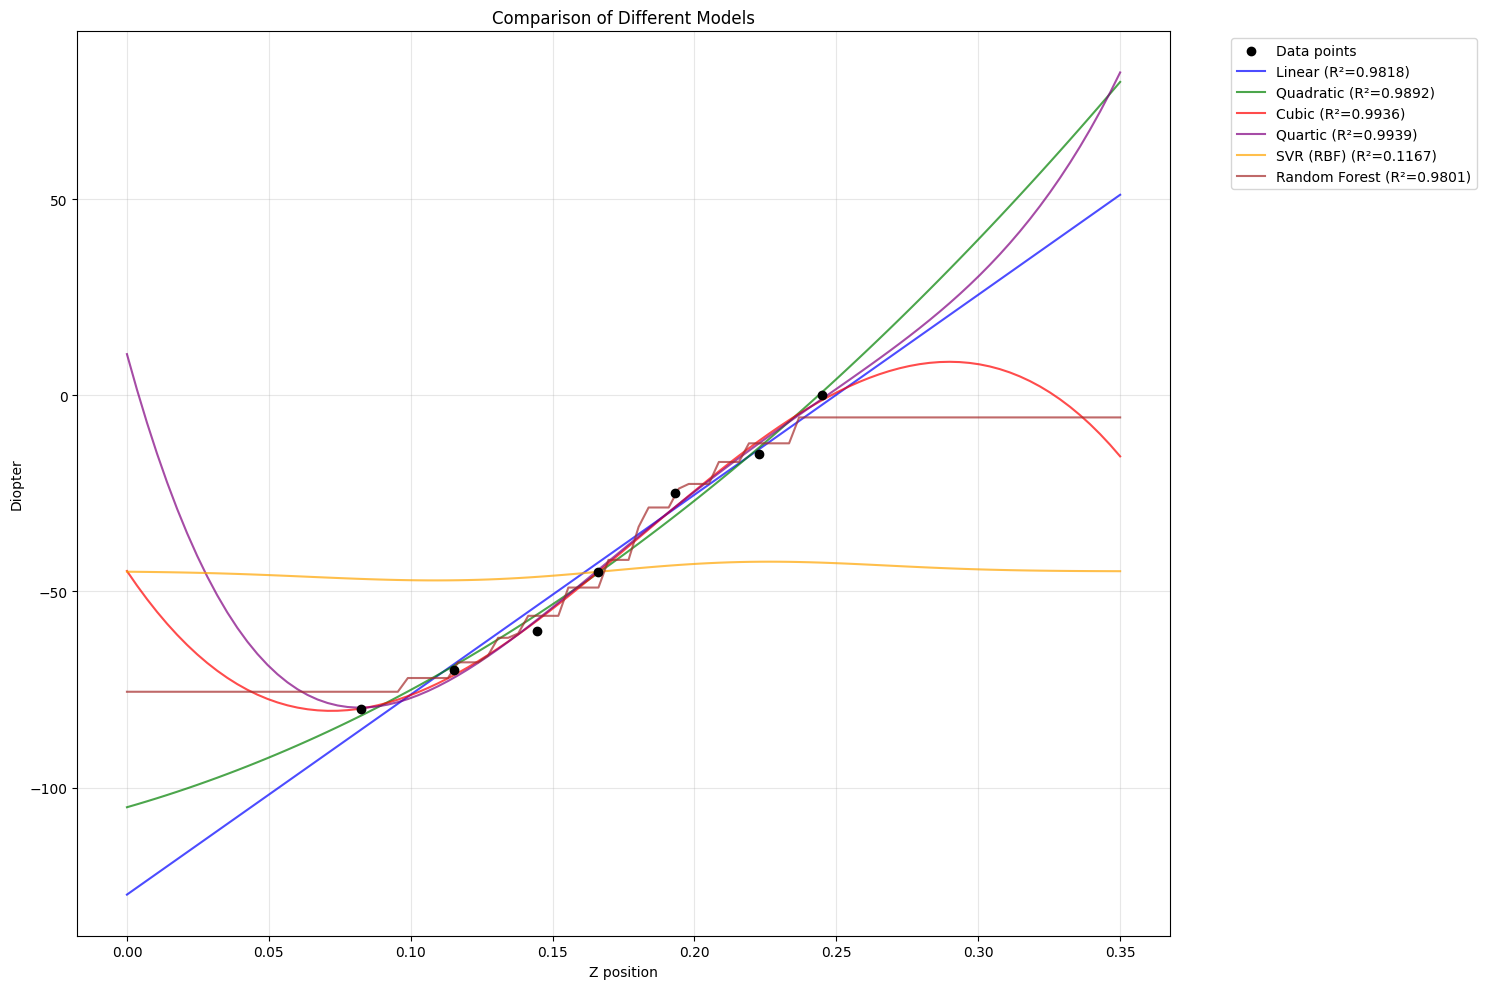


Best Model: Quartic
R² Score: 0.9939
MSE: 4.6842

Model Coefficients:
1: 0.0000
z: -2648.3348
z^2: 25112.0922
z^3: -84109.6681
z^4: 101867.8981


In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Load the data
calibration_df = pd.read_csv("/home/buchsbaum/liquid_lens_calibration_20241112.csv")

z_values = calibration_df["z"].values
dpt_values = calibration_df["dpt"].values

# Create dictionary to store models
models = {
    "Linear": make_pipeline(PolynomialFeatures(1), LinearRegression()),
    "Quadratic": make_pipeline(PolynomialFeatures(2), LinearRegression()),
    "Cubic": make_pipeline(PolynomialFeatures(3), LinearRegression()),
    "Quartic": make_pipeline(PolynomialFeatures(4), LinearRegression()),
    "SVR (RBF)": SVR(kernel="rbf"),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
}

# Fit models and calculate metrics
results = {}
for name, model in models.items():
    # Fit the model
    model.fit(z_values.reshape(-1, 1), dpt_values)

    # Make predictions
    y_pred = model.predict(z_values.reshape(-1, 1))

    # Calculate metrics
    r2 = r2_score(dpt_values, y_pred)
    mse = mean_squared_error(dpt_values, y_pred)

    results[name] = {"r2": r2, "mse": mse, "model": model}

# Print results
print("\nModel Comparison Results:")
print("-" * 50)
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  R² Score: {metrics['r2']:.4f}")
    print(f"  MSE: {metrics['mse']:.4f}")
    print("-" * 50)

# Find best model based on R²
best_model_name = max(results.items(), key=lambda x: x[1]["r2"])[0]
best_model = results[best_model_name]["model"]

# Create visualization
plt.figure(figsize=(15, 10))

# Plot training data
plt.scatter(z_values, dpt_values, color="black", label="Data points", zorder=5)

# Plot all model predictions
z_plot = np.linspace(0.00, 0.35, 100).reshape(-1, 1)
colors = ["blue", "green", "red", "purple", "orange", "brown"]

for (name, model_dict), color in zip(results.items(), colors):
    model = model_dict["model"]
    y_pred = model.predict(z_plot)
    plt.plot(
        z_plot,
        y_pred,
        color=color,
        label=f'{name} (R²={model_dict["r2"]:.4f})',
        alpha=0.7,
    )

plt.xlabel("Z position")
plt.ylabel("Diopter")
plt.title("Comparison of Different Models")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print detailed information about the best model
print(f"\nBest Model: {best_model_name}")
print(f"R² Score: {results[best_model_name]['r2']:.4f}")
print(f"MSE: {results[best_model_name]['mse']:.4f}")

# If the best model is polynomial, print the coefficients
if best_model_name in ["Linear", "Quadratic", "Cubic", "Quartic"]:
    poly_features = best_model.named_steps["polynomialfeatures"]
    linear_reg = best_model.named_steps["linearregression"]
    feature_names = poly_features.get_feature_names_out(["z"])
    coefficients = dict(zip(feature_names, linear_reg.coef_))
    print("\nModel Coefficients:")
    for feature, coef in coefficients.items():
        print(f"{feature}: {coef:.4f}")